# 文本数据的预处理
将文本信息进行转化，转化为一个voc

In [1]:
import re

data_path = "../data/NLP/timemachine.txt"
def read_time_machine():
    with open(data_path) as f:
        lines = f.readlines()
    preprocessed_lines = [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]
    return preprocessed_lines

lines = read_time_machine()
print(len(lines))
print(lines[0])

3229
the time machine by h g wells


In [2]:
def tokenize(lines, token='word'):
    """将文本行拆分为单词或字符词元"""
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('错误：未知词元类型：' + token)

tokens = tokenize(lines)
for i in range(11):
    print(tokens[i])

['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
[]
[]
[]
[]
['i']
[]
[]
['the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him']
['was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and']
['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']


现在提取出所有的单词了，下一步就是给每一个单词一个index，也即是构建一个字典，这样可以更好的放入模型中

In [ ]:
import collections
def count_corpus(tokens):
    """统计词元的频率"""
    if len(tokens) == 0 or isinstance(tokens[0], list):
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens) # 计算每个单词出现的数量，返回一个字典 word: freq

class Vocab:
    # init的目的是构造词表(idx to token和 token to idx)
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key = lambda x: x[1], reverse=True)

        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = { token: idx
                             for idx , token in enumerate(self.idx_to_token)
        }
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1
    
    def __len__(self):
        return len(self.idx_to_token)
    
    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]
        
    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]
    
    @property
    def unk(self):
        return 0
    
    @property
    def token_freqs(self):
        return self._token_freqs

In [4]:
vocab = Vocab(tokens)
print(list(vocab.token_to_idx.items())[:10])

for i in [0, 10]:
    print('文本:', tokens[i])
    print('索引:', vocab[tokens[i]])

[('<unk>', 0), ('the', 1), ('i', 2), ('and', 3), ('of', 4), ('a', 5), ('to', 6), ('was', 7), ('in', 8), ('that', 9)]
文本: ['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
索引: [1, 19, 49, 40, 1420, 1421, 362]
文本: ['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']
索引: [2186, 3, 25, 1044, 363, 113, 7, 1423, 3, 1045, 1]


In [ ]:
def load_corpus_time_machine(max_tokens=-1):
    """返回时光机器数据集的词元索引列表和词表"""
    lines = read_time_machine()
    tokens = tokenize(lines)
    vocab = Vocab(tokens)
    corpus = [token for line in tokens for token in line]
    # corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

corpus, vocab = load_corpus_time_machine()
print(len(corpus))
print(len(vocab))
print(corpus[:10])
print(vocab.token_to_idx[corpus[9]]) # 'time'

32789
4584
['the', 'time', 'machine', 'by', 'h', 'g', 'wells', 'i', 'the', 'time']
19


以下是正式进行的数据处理分析

In [17]:
import random
import torch
import matplotlib.pyplot as plt

corpus, vocab = load_corpus_time_machine()
vocab.token_freqs[:10]

[('the', 2262),
 ('i', 1267),
 ('and', 1245),
 ('of', 1156),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

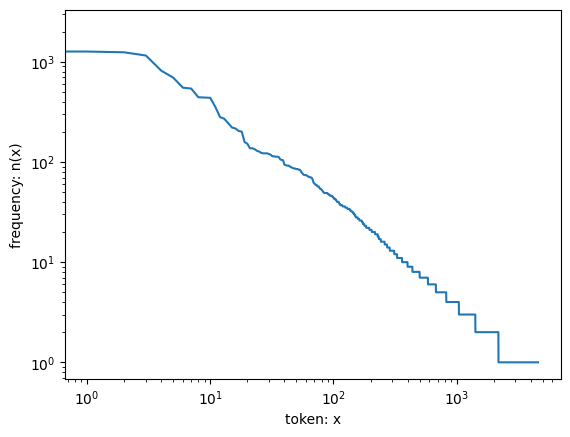

In [19]:
freqs = [freq for token, freq in vocab.token_freqs]
plt.plot(freqs)
plt.xlabel('token: x')
plt.ylabel('frequency: n(x)')
plt.xscale('log')
plt.yscale('log')
plt.show()


In [ ]:
bigram_tokens = [pair for pair in zip(corpus[:-1], corpus[1:])]
bigram_vocab = Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[(('of', 'the'), 309),
 (('in', 'the'), 169),
 (('i', 'had'), 130),
 (('i', 'was'), 112),
 (('and', 'the'), 109),
 (('the', 'time'), 103),
 (('it', 'was'), 99),
 (('to', 'the'), 85),
 (('as', 'i'), 78),
 (('of', 'a'), 73)]

In [ ]:
trigram_tokens = [triple for triple in zip(
    corpus[:-2], corpus[1:-1], corpus[2:])]
trigram_vocab = Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]